In [22]:
import os
import glob
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import json
from astropy.table import Table, Column
from astropy.cosmology import Planck15 as cosmo
from pathlib import Path
from scipy.stats import pearsonr as pr

# Create object to hold all data
all_data = {}

# Keywords for model parameters and latex symbols
keywords = {
    'plateau_duration': {'key': 'Tpt', 'errkey': 'e_Tpt', 'latex': 'Rest-frame plateau duration (days)'},
    'nickel_mass': {'key': 'MNi', 'errkey': 'e_MNi', 'latex': 'Nickel-56 Ejecta Mass (M$_{\\odot}$)'},
    'host_galaxy': {'key': 'Host'},
    'peak_luminosity': {'key': 'logLpeak', 'errkey': 'e_logLpeak', 'latex': 'Peak Luminosity (log(erg s$^{-1}$))'}
}

blast_keywords = {
    'local_sfd': {'latex': '$\Sigma$SFR ($M_\odot yr^{-1} kpc^{-2}$)'},
    'global_aperture_host_log_mass': {'latex': 'Global Stellar Mass (log($M_\odot$))'},
    'global_aperture_host_log_sfr': {'latex': 'Global Star-Formation Rate (log($M_\odot$ yr$^{-1}$))'},
    'global_aperture_host_log_ssfr': {'latex': 'Global Specific Star-Formation Rate (log(yr$^{-1}$))'},
    'local_aperture_host_logzsol': {'latex': 'Local Metallicity (log($Z/Z_\odot$))'},
    'global_aperture_host_logzsol': {'latex': 'Global Metallicity (log($Z/Z_\odot$))'},
    'local_aperture_host_log_age' :{'latex': 'Local Host Stellar Age'}
}

### Importing data from Valenti+2016 

In [23]:
valenti_phys = Table.read(os.path.join('data','valenti16','valenti_phys_bolometric.tsv'), format='ascii', delimiter='|')
valenti_lcpm = Table.read(os.path.join('data','valenti16','valenti_phys_lcpm.tsv'), format='ascii', delimiter='|')
valenti_meta = Table.read(os.path.join('data','valenti16','valenti_metadata.tsv'), format='ascii', delimiter='|')

# Merge metadata into physical parameters table
for col in valenti_meta.keys():
    if col not in valenti_phys.keys() and col not in ['LC','LC_param']:
        col_data = []
        for row in valenti_phys:
            mask = row['Name']==valenti_meta['Name']
            if len(valenti_meta[mask])==1:
                col_data.append(valenti_meta[mask][0][col])
            else:
                col_data.append(None)
        newcol = Column(col_data, name=col)
        valenti_phys.add_column(newcol)

# Sanitize keywords
for col in valenti_lcpm.keys():
    if col not in valenti_phys.keys() and col not in ['LC','LC_param']:
        col_data = []
        for row in valenti_phys:
            mask = row['Name']==valenti_lcpm['Name']
            if len(valenti_lcpm[mask])==1:
                col_data.append(valenti_lcpm[mask][0][col])
            else:
                col_data.append(None)
        newcol = Column(col_data, name=col)
        valenti_phys.add_column(newcol)

for key in ['MNi','e_MNi','Tpt','e_Tpt']:
    data = []
    for v in valenti_phys[key]:
        try:
            data.append(float(v))
        except TypeError:
            data.append(np.nan)
    valenti_phys[key] = data

# Append complete list of metadata into all_data
valenti_phys.meta['sample_name']='Valenti+2016'
all_data['valenti']=valenti_phys

C:\Users\jvasq\AppData\Local\Temp\ipykernel_19404\457811591.py:35: UserWarning: Warning: converting a masked element to nan.
  data.append(float(v))
C:\Users\jvasq\AppData\Local\Temp\ipykernel_19404\457811591.py:35: UserWarning: Warning: converting a masked element to nan.
  data.append(float(v))


### Importing data from Spiro+2014 

In [24]:
spiro_data = Table.read(os.path.join('data','spiro14','spiro_nickel'), format='ascii')

# Append complete list of metadata into all_data
spiro_data.meta['sample_name']='Spiro+2014'
all_data['spiro']=spiro_data

### Importing data from Anderson+2014 (https://ui.adsabs.harvard.edu/abs/2014ApJ...786...67A/abstract)

In [25]:
anderson_data = Table.read(os.path.join('data','anderson14','anderson_fit_data.txt'), format='ascii')

# Sanitize MNi-56
mass = [] ; err_mass = [] ; tpt = [] ; err_tpt = []
for row in anderson_data:
    dat = row['MNi']
    if '$' in dat:
        val = float(dat.split('$')[0])
        err = dat.split('$')[1]

        # Strip out brackets from error
        err = err.replace('{','').replace('}','').replace('^','')
        upper, lower = err.split('_')
        upper = np.abs(float(upper)) ; lower = np.abs(float(lower))

        mass.append(val)
        err_mass.append((upper, lower))

    else:
        mass.append(np.nan)
        err_mass.append((np.nan, np.nan))

    # Get plateau duration
    dat = row['OPTd']
    if '(' in dat:
        val, err = dat.split('(')
        tpt.append(float(val))
        err_tpt.append(float(err.replace(')','')))
    else:
        tpt.append(np.nan)
        err_tpt.append(np.nan)

# Get luminosity and uncertainty
all_lum = [] ; elum = []
for row in anderson_data:
     dat = row['M_max']
     dat = dat.replace(')','').replace('*','')

     if '(' not in dat:
         all_lum.append(np.nan)
         elum.append(np.nan)
         continue

     val, err = dat.split('(')
     err = float(err) * 0.4
     lum = np.log10(3.839e33 * 10**(-0.4 * (float(val)-4.74)))

     all_lum.append(lum)
     elum.append(err)

anderson_data.add_column(Column(all_lum, name='logLpeak'))
anderson_data.add_column(Column(elum, name='e_logLpeak'))
    

# Change column names
anderson_data.rename_column('SN','Name')

anderson_data['MNi']=mass
anderson_data.add_column(Column(err_mass, name='e_MNi'))
anderson_data.add_column(Column(tpt, name='Tpt'))
anderson_data.add_column(Column(err_tpt, name='e_Tpt'))

# Add host data from Table 1 data in Anderson+2014
hosts=[]
names=[]
with open(os.path.join('data', 'anderson14','anderson_sample.txt'), 'r') as f:
    for line in f:
        names.append(line.split()[0])
        hosts.append(line.split()[1])

names = np.array(names)
hosts = np.array(hosts)

a_hosts=[]
for row in anderson_data:
    mask = names==row['Name']
    if len(names[mask])==1:
        a_hosts.append(hosts[mask][0])
    else:
        a_hosts.append('--')

anderson_data.add_column(Column(a_hosts, name='Host'))

anderson_data.meta['sample_name']='Anderson+2014'
all_data['anderson']=anderson_data

### Importing data from Martinez+2022 (https://ui.adsabs.harvard.edu/abs/2022A%26A...660A..41M)

In [26]:
martinez_data = Table.read(os.path.join('data','martinez22','table_results.txt'), format='ascii', delimiter='&')

# Sanitize Martinez data so Nickel mass is formatted as a float with error as a tuple
mass = [] ; err_mass = []
for row in martinez_data:
    dat = row['MNi']
    if '$' in dat:
        val = float(dat.split('$')[0])
        err = dat.split('$')[1]

        # Strip out brackets from error
        err = err.replace('{','').replace('}','').replace('^','')
        upper, lower = err.split('_')
        upper = np.abs(float(upper)) ; lower = np.abs(float(lower))

        mass.append(val)
        err_mass.append((upper, lower))

    else:
        mass.append(np.nan)
        err_mass.append((np.nan, np.nan))

martinez_data['MNi']=mass
martinez_data.add_column(Column(err_mass, name='e_MNi'))

# Append complete list of metadata into all_data
martinez_data.meta['sample_name']='Martinez+2022'
all_data['martinez']=martinez_data

### Importing YSE data

In [27]:
yse_data = Table.read(os.path.join('data','yse','yse_data.txt'), format='ascii')

for key in ['e_Tpt','e_MNi']:
    data = []
    for row in yse_data:
        data.append([float(r) for r in row[key].split(',')])
    yse_data[key]=data

yse_data.meta['sample_name']='YSE'
all_data['yse']=yse_data

### Plateau Duration versus Nickel

valenti [ nan  4.5  0.5  2.   1.  10.   nan  5.5  1.5  1.5 10.   1.   2.   1.
  1.   nan  nan  1.   3.1  5.   nan  4.5  nan  4.   4.   0.5  nan  nan
  nan  1.   1.2  3.   5.   2.   2.   8.   2.   4.   5. ] [   nan 0.0007 0.0003 0.0127 0.0038 0.0008    nan 0.0079 0.0102 0.0002
 0.0098 0.01   0.0043 0.0019 0.0006 0.0007 0.0134 0.0119 0.0023 0.0047
 0.0102 0.0002 0.004  0.0046 0.0086 0.0002 0.0175 0.0006    nan 0.0007
 0.0021 0.0017 0.0116 0.0162 0.0002 0.0033 0.0012 0.0059 0.0051]
2013ai 0 nan nan nan nan
2013bu 1 102.8 0.0021 4.5 0.0007
2013fs 2 86.2 0.0545 0.5 0.0003
LSQ13dpa 3 129.9 0.0714 2.0 0.0127
2014cy 4 122.6 0.0037 1.0 0.0038
2014dw 5 90.8 0.0094 10.0 0.0008
LSQ14gv 6 nan nan nan nan
ASASSN-14dq 7 101.5 0.0461 5.5 0.0079
ASASSN-14gm 8 110.6 0.0767 1.5 0.0102
ASASSN-14ha 9 136.9 0.0014 1.5 0.0002
2015W 10 109.2 0.0314 10.0 0.0098
2013ab 11 102.0 0.0588 1.0 0.01
2013by 12 85.8 0.032 2.0 0.0043
2013ej 13 99.4 0.0207 1.0 0.0019
2014G 14 87.8 0.0341 1.0 0.0006
1987A 15 nan 0.075 nan

c:\Users\jvasq\anaconda3\envs\TypeII\lib\site-packages\matplotlib\axes\_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
c:\Users\jvasq\anaconda3\envs\TypeII\lib\site-packages\matplotlib\axes\_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
c:\Users\jvasq\anaconda3\envs\TypeII\lib\site-packages\matplotlib\axes\_axes.py:1105: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
c:\Users\jvasq\anaconda3\envs\TypeII\lib\site-packages\matplotlib\axes\_axes.py:1106: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
c:\Users\jvasq\anaconda3\envs\TypeII\lib\site-packages\matplotlib\axes\_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
c:\Users\jvasq\anaconda3\envs\TypeII\lib\site-packages\matplotlib\axes\_axes.py:1184: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[.

2005K 51 nan nan nan [[nan]
 [nan]]
2005Z 52 78.8 nan 7.0 [[nan]
 [nan]]
2005af 53 104.0 0.026 16.0 [[0.012]
 [0.021]]
2005an 54 77.7 nan 6.0 [[nan]
 [nan]]
2005dk 55 84.2 nan 7.0 [[nan]
 [nan]]
2005dn 56 79.8 nan 7.0 [[nan]
 [nan]]
2005dt 57 112.9 nan 10.0 [[nan]
 [nan]]
2005dw 58 92.6 nan 10.0 [[nan]
 [nan]]
2005dx 59 85.6 nan 8.0 [[nan]
 [nan]]
2005dz 60 81.9 nan 6.0 [[nan]
 [nan]]
2005es 61 nan nan nan [[nan]
 [nan]]
2005gk 62 nan nan nan [[nan]
 [nan]]
2005hd 63 nan nan nan [[nan]
 [nan]]
2005lw 64 107.2 nan 11.0 [[nan]
 [nan]]
2005me 65 76.9 nan 7.0 [[nan]
 [nan]]
2006Y 66 47.5 nan 6.0 [[nan]
 [nan]]
2006ai 67 63.3 nan 7.0 [[nan]
 [nan]]
2006bc 68 nan nan nan [[nan]
 [nan]]
2006be 69 72.9 nan 7.0 [[nan]
 [nan]]
2006bl 70 nan nan nan [[nan]
 [nan]]
2006ee 71 85.2 nan 6.0 [[nan]
 [nan]]
2006it 72 nan nan nan [[nan]
 [nan]]
2006iw 73 nan nan nan [[nan]
 [nan]]
2006ms 74 nan nan nan [[nan]
 [nan]]
2006qr 75 96.9 nan 8.0 [[nan]
 [nan]]
2007P 76 88.3 nan 7.0 [[nan]
 [nan]]
2007U 77 nan

ValueError: 'xerr' (shape: (4,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'x' (shape: (1,))

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


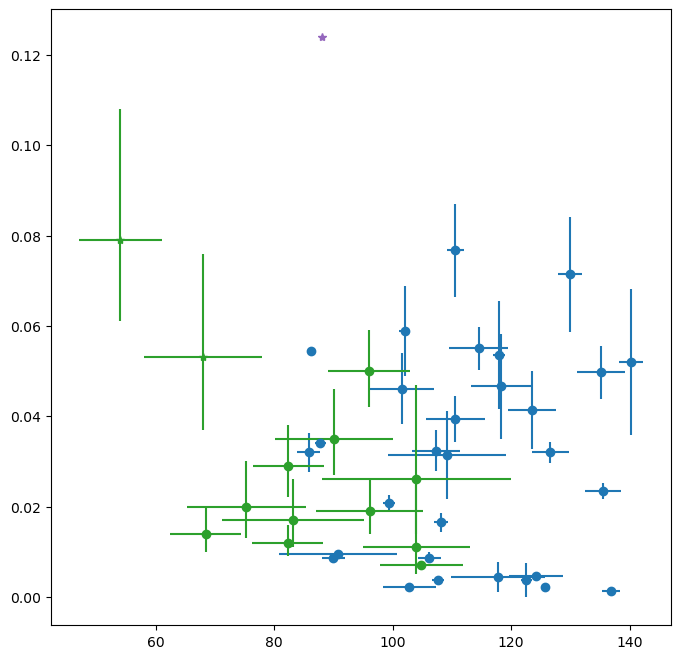

In [64]:
def make_plot(all_data, param1='', param2=''):
    fig, ax = plt.subplots(figsize=(8,8))
    starred = ['2020hgw', '2020jfo', '2020jww', '1992af', '2002hx']
    key1=keywords[param1]['key']
    key2=keywords[param2]['key']
    ekey1=keywords[param1]['errkey']
    ekey2=keywords[param2]['errkey']
    all_x = [] 
    all_y = []
    
    sample_colors = dict(zip(all_data.keys(), [f'C{x}' for x in range(len(all_data.keys()))]))
    for key in all_data.keys():
        table = all_data[key]
        names = table['Name']
        if key1 in table.keys() and key2 in table.keys() and ekey1 in table.keys() and ekey2 in table.keys():
            xerr = np.array(table[ekey1].data)
            yerr = np.array(table[ekey2].data)
            print(key, xerr, yerr)
            
            t1 = table[key1]
            t2 = table[key2]
            mask = ~np.isnan(t1) & ~np.isnan(t2)
            t1 =t1[mask]
            t2 = t2[mask]
            rval = pr(t1, t2)
            r_sq = rval[0]**2
            r_sq = '%.4f'%r_sq
            if len(xerr.shape)==2:
                xerr = xerr.transpose()
            if len(yerr.shape)==2:
                yerr = yerr.transpose()
            
            first = True
            for i, name in enumerate(names):
                #print(name)
                if name in ['1986L']:
                    continue
                if name in starred:
                    fmt = '*'
                else:
                    fmt = 'o'
                
                if key == 'anderson':
                    yerr_plot = np.array([yerr[:,i],]).T
                else:
                    yerr_plot = yerr[i]
                    
                print(name, i, table[key1][i], table[key2][i], xerr[i], yerr_plot)
                if first:
                    ax.errorbar(table[key1][i], table[key2][i], xerr=xerr[i], yerr=yerr_plot, linestyle='None',\
                        color = sample_colors[key], label=table.meta['sample_name'], marker=fmt)
                    first = False
                else:
                    ax.errorbar(table[key1][i], table[key2][i], xerr=xerr[i], yerr=yerr_plot, linestyle='None',\
                        color = sample_colors[key], marker=fmt)
                    
            ax.text(table[key1].min(), 0, f'$r^2 =${r_sq}')

    ax.set_xlabel(keywords[param1]['latex'], fontsize = 20)
    ax.set_ylabel(keywords[param2]['latex'], fontsize = 20)

    return(fig, ax)

fig, ax = make_plot(all_data, 'plateau_duration', 'nickel_mass')

# MESA theoretical data from: https://www.aanda.org/articles/aa/pdf/2020/10/aa38393-20.pdf
# Odd columns are Ni-56 and even columns are plateau duration
colors = ['blue','green','red']
for i,file in enumerate(sorted(glob.glob(os.path.join('data','theory','mesa_nickel*.txt')))):
    filebase = os.path.basename(file)
    value = float(filebase.split('_')[-1].replace('.txt','').replace('foe',''))

    theory_table = Table.read(file, names=('MNi','Tpt'), format='ascii')

    ax.plot(theory_table['Tpt'], theory_table['MNi'], linestyle='dashed', label=f'MESA, $E={value}$ foe')
    
ax.text(63, 0.045, '2020jfo')
ax.text(89.5, 0.125, '2020hgw')
ax.text(93, 0.11, '2020jww')
ax.text(109, 0.07, '2020rth')
ax.legend(fontsize = 'large')
ax.text(54, 0.079, '1992af')
ax.text(67.3, 0.053, '2002hx')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


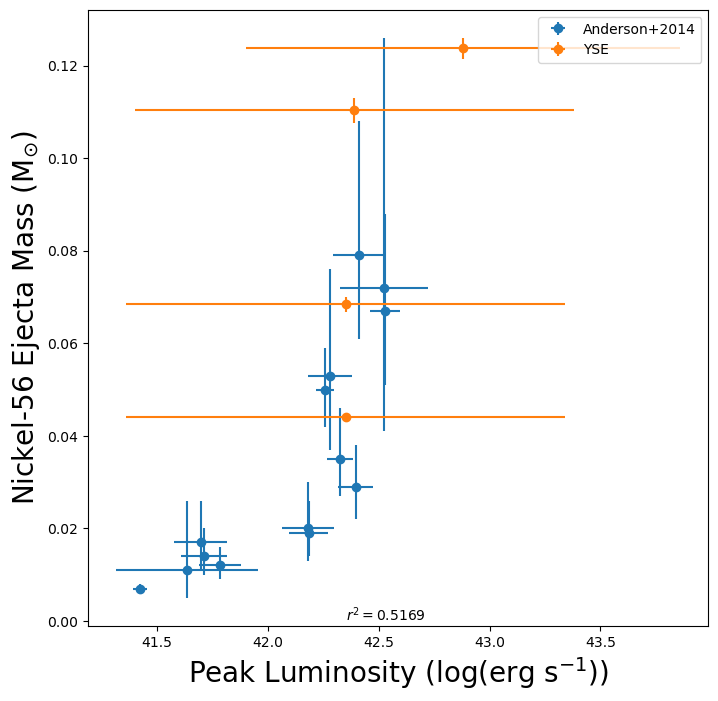

In [29]:
fig, ax = make_plot(all_data, 'peak_luminosity', 'nickel_mass')
plt.legend()

In [30]:
import requests

def get_blast_data(name, suppress_output=False):
    fname=os.path.join('data','blast',name+'.json')
    if os.path.exists(fname):
        with open(fname, 'r') as f:
            data = json.load(f)
            return(data)
    else:
        url = f'https://blast.scimma.org/api/transient/get/{name}'
        r = requests.get(url)
        if r.status_code==200:
            data = json.loads(r.content)
            with open(fname, 'w') as f:
                json.dump(data, f)
        else:
            if not suppress_output: print(f'Could not get Blast data for: {name}')

Redshift for 2013ai is missing
Redshift for 2013bu is missing
Could not get Blast data for: LSQ13dpa
Redshift for 2014dw is missing
Could not get Blast data for: LSQ14gv
Could not get Blast data for: ASASSN-14dq
Could not get Blast data for: ASASSN-14gm
Could not get Blast data for: ASASSN-14ha
Redshift for 2015W is missing
Redshift for 1987A is missing
Redshift for 1990E is missing
No local aperture for 2001X
Redshift for 2002hh is missing
Redshift for 2003hn is missing
Redshift for 2004et is missing
Redshift for 2005cs is missing
Redshift for 2007it is missing
Redshift for 2009bw is missing
Redshift for 2009dd is missing
Redshift for 2012A is missing
Could not get Blast data for: LSQ13dpa
Could not get Blast data for: LSQ14gv
Could not get Blast data for: ASASSN-14dq
Could not get Blast data for: ASASSN-14gm
Could not get Blast data for: ASASSN-14ha
Redshift for 1997D is missing
Redshift for 1999br is missing
Redshift for 2001dc is missing
Redshift for 2004et is missing
Redshift for 

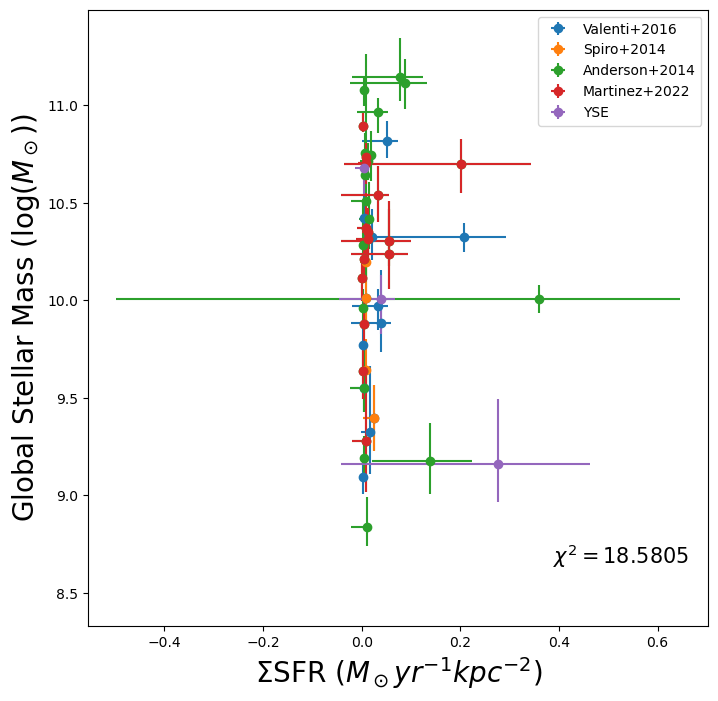

In [31]:
def get_local_sfd(data, suppress_output=False):

    # Return a contextual error to flag objects that need to be re-run
    error = ''
    
    # Get area of local aperture in kpc^2
    redshift = data['host_redshift']
    if redshift is None:
        name = data['transient_name']
        if not suppress_output: print(f'Redshift for {name} is missing')
        return(np.nan, (np.nan, np.nan), 'redshift')
        
    a = data['local_aperture_semi_major_axis_arcsec']
    b = data['local_aperture_semi_minor_axis_arcsec']

    if a is None or b is None:
        name = data['transient_name']
        if not suppress_output: print(f'No local aperture for {name}')
        return(np.nan, (np.nan, np.nan), 'local_aperture')

    d = cosmo.angular_diameter_distance(redshift).value * 1000.0 # Convert to kpc
    area = np.pi * a/3600 * np.pi/180.0 * d * b/3600 * np.pi/180.0 * d

    # Get local star-formation rate
    val = data['local_aperture_host_log_sfr_50']
    if val is None:
        return(np.nan, (np.nan, np.nan), 'local_aperture')

    val = 10**val
    
    eup = 10**data['local_aperture_host_log_sfr_84'] - val
    elo = val - 10**data['local_aperture_host_log_sfr_16']

    val = val / area
    unc = (eup/area, elo/area)
    
    

    return(val, unc, error)
    

def make_blast_plot(all_data, param1, param2, suppress_output=False):
    fig, ax = plt.subplots(figsize=(8,8))

    blast1=False
    blast2=False

    blast_errors = {}
    all_x = []
    all_y = []
    all_xerr_upper = []
    all_xerr_lower = []
    all_yerr_upper = []
    all_yerr_lower = []

    if param1 in keywords.keys():
        key1=keywords[param1]['key']
        ekey1=keywords[param1]['errkey']
        latex1=keywords[param1]['latex']
    elif param1.startswith('global') or param1.startswith('local'):
        latex1=blast_keywords[param1]['latex']
        blast1=True
    if param2 in keywords.keys():
        key2=keywords[param2]['key']
        ekey2=keywords[param2]['errkey']
        latex2=keywords[param2]['latex']
    elif param2.startswith('global') or param2.startswith('local'):
        latex2=blast_keywords[param2]['latex']
        blast2=True

    for key in all_data.keys():
        table = all_data[key]

        if not blast1 and key1 in table.keys() and ekey1 in table.keys():
            x = np.array(table[key1].data)
            xerr = np.array(table[ekey1].data)

        elif blast1:
            x = [] ; xerr = []
            for row in table:
                data = get_blast_data(row['Name'], suppress_output=suppress_output)

                if data is None:
                    if row['Name'] not in blast_errors.keys():
                        blast_errors[row['Name']]='missing'
                    x.append(np.nan)
                    xerr.append((np.nan, np.nan))
                    continue

                if param1=='local_sfd':
                    val, unc, error = get_local_sfd(data, suppress_output=suppress_output)
                    if error:
                        if row['Name'] not in blast_errors.keys():
                            blast_errors[row['Name']]=error
                else:
                    val = data[param1+'_50']
                    if val is None:
                        x.append(np.nan)
                        xerr.append((np.nan, np.nan))
                        continue
                    eup = data[param1+'_84']-val
                    elo = val - data[param1+'_16']
                    unc = (eup, elo)

                x.append(val)
                xerr.append(unc)
                
        else:
            continue

        if not blast2 and key2 in table.keys() and ekey2 in table.keys():
            y = np.array(table[key2].data)
            yerr = np.array(table[ekey2].data)

        elif blast2:
            y = [] ; yerr = []
            for row in table:
                data = get_blast_data(row['Name'], suppress_output=suppress_output)

                if data is None:
                    if row['Name'] not in blast_errors.keys():
                        blast_errors[row['Name']]='missing'
                    y.append(np.nan)
                    yerr.append((np.nan, np.nan))
                    continue

                if param2=='local_sfd':
                    val, unc, error = get_local_sfd(data, suppress_output=suppress_output)
                    if error:
                        if row['Name'] not in blast_errors.keys():
                            blast_errors[row['Name']]=error
                            
                elif param2 == 'local_aperture_host_log_age':
                    val = data['local_aperture_host_log_age_50']
                    if val is None:
                        y.append(np.nan)
                        yerr.append((np.nan, np.nan))
                        continue
                    elif val < 1.5:
                        y.append(np.nan)
                        yerr.append((np.nan, np.nan))
                        continue
                    else:
                        eup = data['local_aperture_host_log_age_84'] - val
                        elo = val -data['local_aperture_host_log_age_16']   
                        unc = (eup, elo)
                    
                else:
                    val = data[param2+'_50']
                    if val is None:
                        y.append(np.nan)
                        yerr.append((np.nan, np.nan))
                        continue
                    eup = data[param2+'_84']-val
                    elo = val - data[param2+'_16']
                    unc = (eup, elo)

                y.append(val)
                yerr.append(unc)
        else:
            continue

        xerr = np.array(xerr)
        yerr = np.array(yerr)

        if len(xerr.shape)==2:
            xerr = xerr.transpose()
        if len(yerr.shape)==2:
            yerr = yerr.transpose()
        
        
        x1 = np.array(x)
        y1 = np.array(y)
        x1err = np.array(xerr)
        y1err = np.array(yerr)
        
        mask = ~np.isnan(x1) & ~np.isnan(y1)
        x1 =x1[mask]
        y1 = y1[mask]
        
        all_x.extend(x1)
        all_y.extend(y1)

        if len(x1err.shape)==2:
            x1err = x1err[:,mask]
            all_xerr_upper.extend(x1err[0,:])
            all_xerr_lower.extend(x1err[1,:])
        else:
            x1err = x1err[mask]
            all_xerr_upper.extend(x1err)
            all_xerr_lower.extend(x1err)

        if len(y1err.shape)==2:
            y1err = y1err[:,mask]
            all_yerr_upper.extend(y1err[0,:])
            all_yerr_lower.extend(y1err[1,:])
        else:
            y1err = y1err[mask]
            all_yerr_upper.extend(y1err)
            all_yerr_lower.extend(y1err)

        ax.errorbar(x, y, xerr=xerr, yerr=yerr, label=table.meta['sample_name'], fmt='o')

    all_x = np.array(all_x)
    all_y = np.array(all_y)
    all_xerr_upper = np.array(all_xerr_upper)
    all_xerr_lower = np.array(all_xerr_lower)
    all_yerr_upper = np.array(all_yerr_upper)
    all_yerr_lower = np.array(all_yerr_lower)

    with open(f'{param1}_vs_{param2}.csv','w') as f:
        f.write(f'{param1},{param1}_err_upper,{param1}_err_lower,{param2},{param2}_err_upper,{param2}_err_lower \n')
        for i in np.arange(len(all_x)):
            f.write(f'{all_x[i]},{all_xerr_upper[i]},{all_xerr_lower[i]},{all_y[i]},{all_yerr_upper[i]},{all_yerr_lower[i]}\n')

    from scipy.odr import ODR, Model, Data, RealData

    all_xerr_val = np.array([np.max([all_xerr_upper[i],all_xerr_lower[i]]) for i in np.arange(len(all_x))])
    all_yerr_val = np.array([np.max([all_yerr_upper[i],all_yerr_lower[i]]) for i in np.arange(len(all_y))])

    def linear(beta, x):
        return(beta[0]+beta[1]*x)

    data = RealData(all_x, all_y, sx=all_xerr_val, sy=all_yerr_val)
    model = Model(linear)

    odr = ODR(data, model, [1,0])
    odr.set_job(fit_type=2)
    output = odr.run()

    #r_sq = output.cov_beta[1,1]/np.sum(all_xerr_val*all_yerr_val)
    r_sq = '%.4f'%output.res_var
    
    ax.text(0.75, 0.1, f'$\chi^2 = ${r_sq}', transform=ax.transAxes, fontsize = 15)

    ax.set_xlabel(latex1, fontsize = 20)
    ax.set_ylabel(latex2, fontsize = 20)

    return(fig, ax, blast_errors)
    

fig, ax, errors = make_blast_plot(all_data, 'local_sfd', 'global_aperture_host_log_mass')
plt.legend()

In [32]:
yse_transients_ref = Table.read(os.path.join('data','transients.ref'), format='ascii')

outfile = open('blast_missing.txt', 'w')

for key in errors.keys():
    if errors[key]=='missing':
        mask = yse_transients_ref['name']==key
        if len(yse_transients_ref[mask])==1:
            ra = yse_transients_ref[mask][0]['ra']
            dec = yse_transients_ref[mask][0]['dec']
            print(key, ra, dec)
            outfile.write(f'{key} {ra} {dec} \n')
outfile.close()

1992af 307.667708333333 -42.3097777777778
2006iw 350.331166666667 0.25975
2008ho 36.2666666666667 -24.8006666666667
2009au 194.941666666667 -29.6020833333333


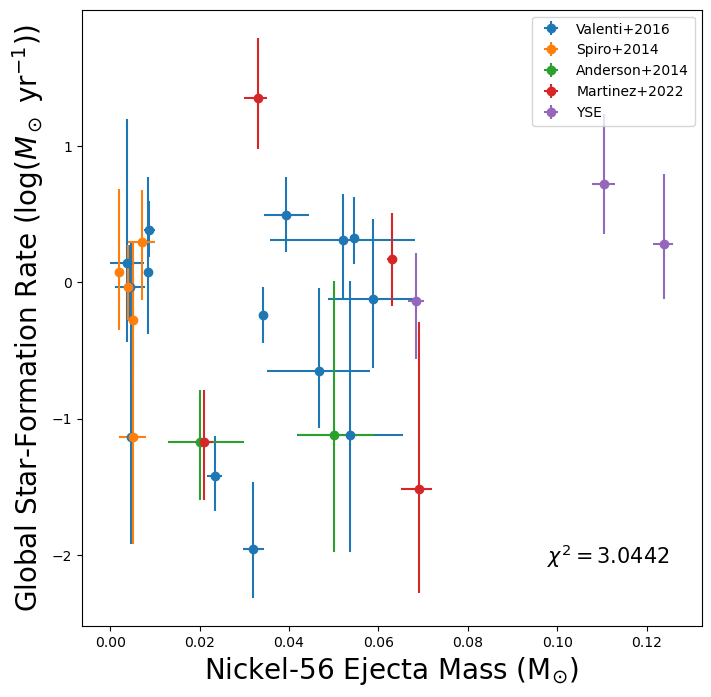

In [33]:
fig, ax, errors = make_blast_plot(all_data, 'nickel_mass','global_aperture_host_log_sfr', suppress_output=True)
plt.legend()

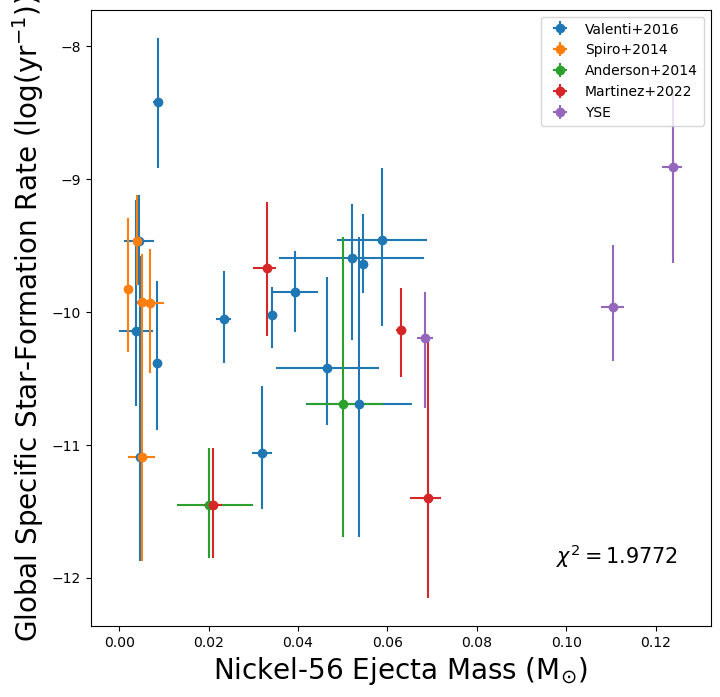

In [34]:
fig, ax, errors = make_blast_plot(all_data, 'nickel_mass','global_aperture_host_log_ssfr', suppress_output=True)
plt.legend()

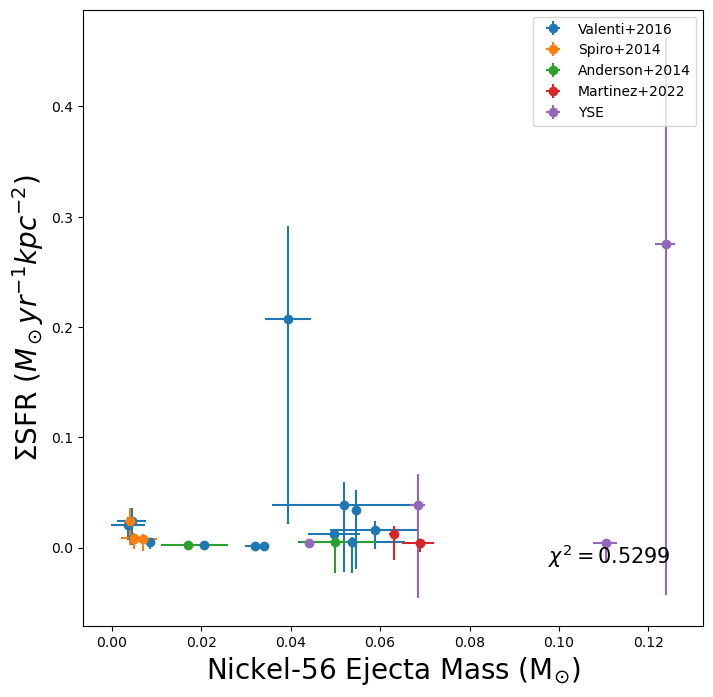

In [35]:
fig, ax, errors = make_blast_plot(all_data,'nickel_mass', 'local_sfd', suppress_output=True)
plt.legend()

In [36]:
# fig, ax, errors = make_blast_plot(all_data,'nickel_mass', 'global_aperture_host_log_sfr', suppress_output=True)
# plt.legend()

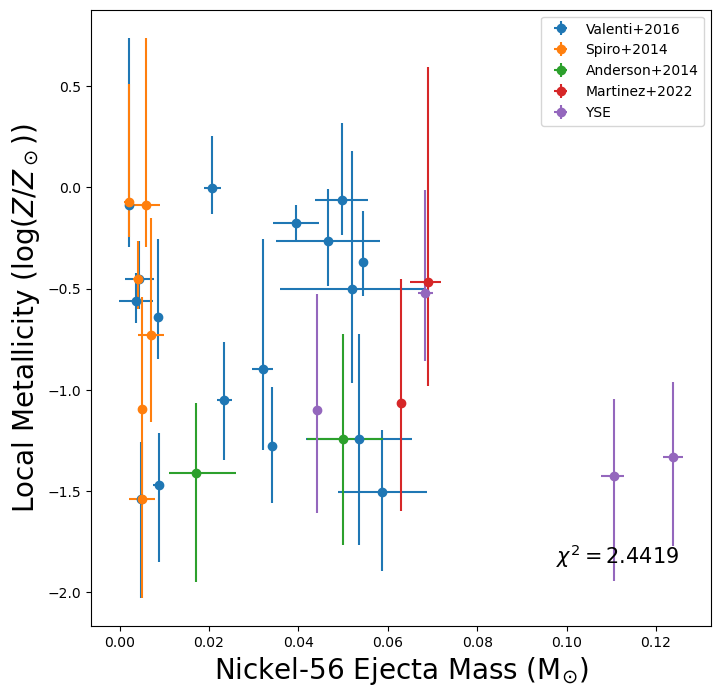

In [37]:
fig, ax, errors = make_blast_plot(all_data, 'nickel_mass', 'local_aperture_host_logzsol', suppress_output=True)
plt.legend()

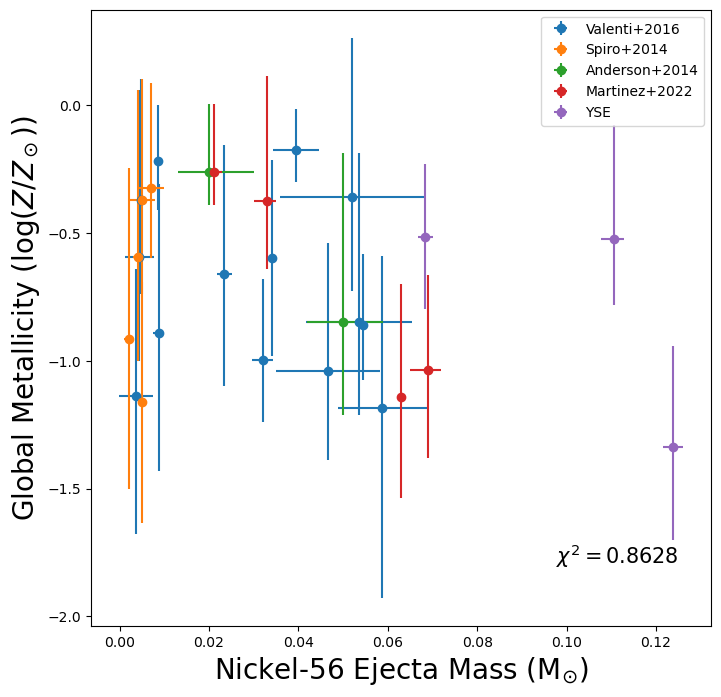

In [38]:
fig, ax, errors = make_blast_plot(all_data,'nickel_mass', 'global_aperture_host_logzsol', suppress_output=True)
plt.legend()

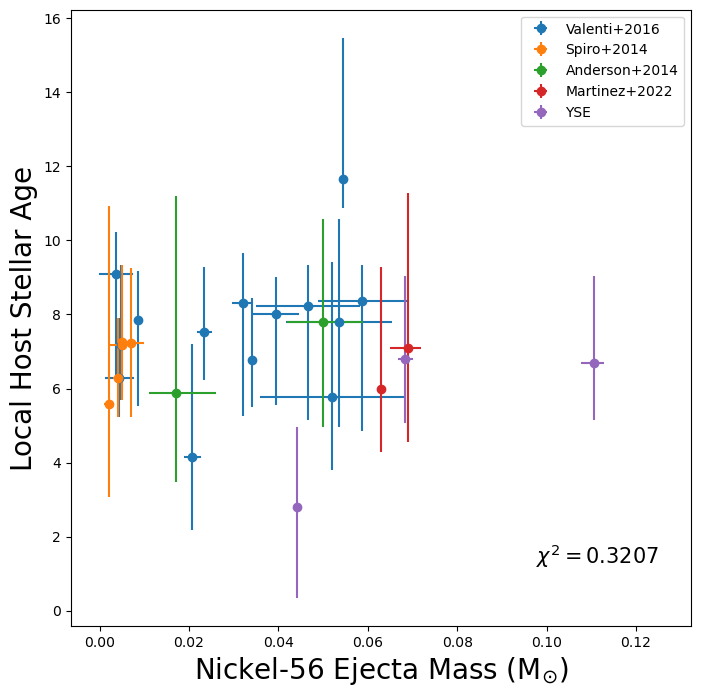

In [39]:
make_blast_plot(all_data, 'nickel_mass', 'local_aperture_host_log_age', suppress_output=True)
plt.legend()

Could not get Blast data for: LSQ13dpa
Could not get Blast data for: LSQ14gv
Could not get Blast data for: ASASSN-14dq
Could not get Blast data for: ASASSN-14gm
Could not get Blast data for: ASASSN-14ha
Could not get Blast data for: 1992af
Could not get Blast data for: 2005gk
Could not get Blast data for: 2006iw
Could not get Blast data for: 2008ho
Could not get Blast data for: 2009au


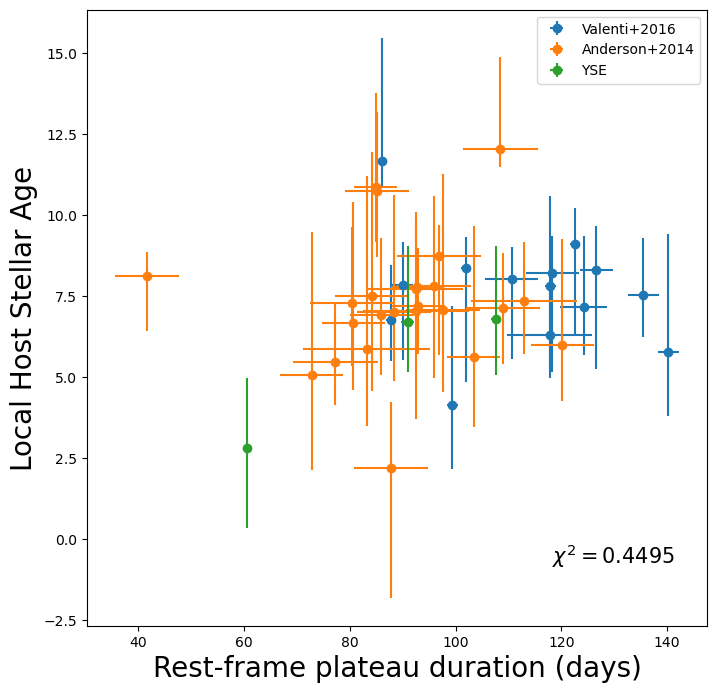

In [40]:
make_blast_plot(all_data, 'plateau_duration', 'local_aperture_host_log_age')
plt.legend()

In [42]:
all_data.values()

dict_values([<Table length=39>
    Name    logL1(0)    S1     e_S1  n_e_S1 ...    M0      E_M0    e_M0     P0  
   str11    float64  float64 float64  str1  ...  object   object  object  object
----------- -------- ------- ------- ------ ... -------- ------- ------- -------
     2013ai    41.62 -0.0081  0.0001     -- ...     None    None    None    None
     2013bu    41.24 -0.0044  0.0003     -- ... 39.73643 0.00011  0.0001 -0.0038
     2013fs    42.47 -0.0146  0.0009     -- ... 41.17148  0.0001   9e-05 -0.0038
   LSQ13dpa    42.02 -0.0042  0.0006     -- ... 41.16555   7e-05  0.0001 -0.0038
     2014cy    41.66  -0.006  0.0005     -- ... 39.92448  0.0001  0.0001 -0.0038
     2014dw    42.23 -0.0135  0.0005     -- ...  40.5177 0.00011  0.0001 -0.0058
    LSQ14gv    42.19 -0.0081  0.0014     -- ...     None    None    None    None
ASASSN-14dq    42.36 -0.0098  0.0004     -- ... 41.06156 0.00011  0.0001 -0.0038
ASASSN-14gm     42.1  -0.003  0.0003     -- ... 41.21063 0.00011  0.0001 -0.00